In [1]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex" : "True",
    "font.family": "Times"
})

from scipy.linalg import eigh
from scipy.fft import fft2

# Hamiltonians

In [2]:
def HamPBC(N,J=1):
    dk = 2*np.pi/N
    # Considering the fact that scipy.fft.fft2 implements
    # a FBZ going from 0 to 2*pi, we have take into account a 
    # pi shift in the definition of k
    k = np.linspace(-np.pi,np.pi-dk,N) - np.pi
    kx, ky = np.meshgrid(k,k)

    A = np.diag(J*np.ravel(2 - 2*np.cos(ky)))
    C = np.diag(J*np.ravel(2 - 2*np.cos(kx)))
    B = -np.diag(J*(1 - np.ravel(np.exp(-1.j*kx))) * (1 - np.ravel(np.exp(-1.j*ky))))
    A2 = np.roll(fft2(A/N**2)[::-1],1,axis=0)
    C2 = np.roll(fft2(C/N**2)[::-1],1,axis=0)
    B2 = np.roll(fft2(B/N**2)[::-1],1,axis=0)

    H = np.block([
        [A2,B2],
        [np.transpose(np.conjugate(B2)),C2]
    ])

    H = np.round(H,0)
    
    return np.real(H)

In [3]:
def HamOBC(N,J=1):
    dk = 2*np.pi/(N+2)
    k = np.linspace(-np.pi,np.pi-dk,N+2) - np.pi
    kx, ky = np.meshgrid(k,k)

    A = np.diag(J*np.ravel(2 - 2*np.cos(ky)))
    C = np.diag(J*np.ravel(2 - 2*np.cos(kx)))
    B = -np.diag(J*(1 - np.ravel(np.exp(-1.j*kx))) * (1 - np.ravel(np.exp(-1.j*ky))))
    A2 = np.roll(fft2(A/(N+2)**2)[::-1],1,axis=0)
    C2 = np.roll(fft2(C/(N+2)**2)[::-1],1,axis=0)
    B2 = np.roll(fft2(B/(N+2)**2)[::-1],1,axis=0)
    
    mask = np.ones(((N+2)**2,(N+2)**2),dtype="bool")
    mask[:N+2,:] = mask[(N+2)*(N+1):,:] = False
    mask[:,:N+2] = mask[:,(N+2)*(N+1):] = False
    mask[::N+2,:] = mask[:,::N+2] = False
    mask[N+1::N+2,:] = mask[:,N+1::N+2] = False
    
    A2 = A2[mask].reshape(N**2,N**2)
    B2 = B2[mask].reshape(N**2,N**2)
    C2 = C2[mask].reshape(N**2,N**2)
    
    H = np.block([
        [A2,B2],
        [np.transpose(np.conjugate(B2)),C2]
    ])

    H = np.round(H,0)
    
    return np.real(H)

In [4]:
def HamOBC2(N,J=1):
    
    H = HamOBC(N)
    H[:N,:] = H[:,:N] = 0
    H[N**2 + N-1::N,:] = H[:,N**2 + N-1::N] = 0
    
    return H

In [5]:
def HamOBC3(N,J=1):
    
    H = HamOBC(N)
    H[:N**2:N,:] = H[:,:N**2:N] = 0
    H[N*(2*N-1):,:] = H[:,N*(2*N-1):] = 0
    
    return H

# Decay rate

According to the Markovian theory, the decay rate of an emitter coupled locally to a lattice can be written as
\begin{equation}
    \Gamma = -\frac{1}{N^2}\text{Im}\Big[ \sum_n \frac{|g_n|^2}{\omega_n - \omega_a +i\eta}\Big]
\end{equation}
where $g_n$ is the coupling constant of the atom with the $n-th$ eigenstate and $\omega_n$ its energy.

## Periodic Boundary Conditions

As expected for a 2D system, the decay rate is indipendent from the position under periodic boundary conditions.

In [152]:
N = 30
J = 1

g = 0.1
om_a = np.linspace(-3,9,500)

In [153]:
eigval1, eigvect1 = eigh(HamPBC(N))

In [154]:
dos = np.zeros(500,dtype="complex")
eta = -2*np.pi/(N**2)

for i in range(0,500):
    for j in range(2*N**2):

        dos[i] += np.abs(eigvect1[1,j])**2/(om_a[i] - eigval1[j] + 1.j*eta)

    dos[i] *= g**2 / N**2
#rhoA = np.transpose(np.imag(rho1[:N**2].reshape(N,N)))/(N**2)
#rhoB = np.transpose(np.imag(rho1[N**2:].reshape(N,N)))/(N**2)

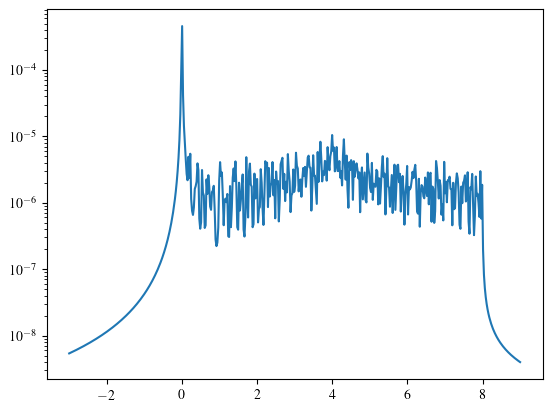

In [155]:
fig = plt.figure()

#plt.plot(om_a,np.real(dos))
plt.plot(om_a,np.imag(dos))

plt.yscale("log")
plt.show()

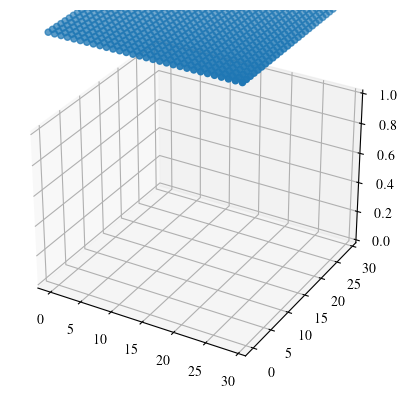

In [81]:
fig = plt.figure()
ax = plt.axes(projection="3d")

arr = np.arange(0,N,1)
Nx, Ny = np.meshgrid(arr,arr)

ax.scatter3D(Nx, Ny, rhoA)

ax.set_zlim(0,1e-7)

plt.show()

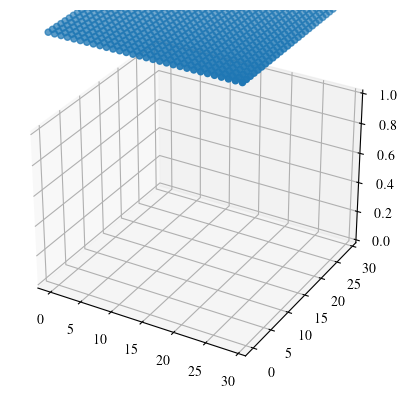

In [82]:
fig = plt.figure()
ax = plt.axes(projection="3d")

arr = np.arange(0,N,1)
Nx, Ny = np.meshgrid(arr,arr)

ax.scatter3D(Nx, Ny, rhoB)

ax.set_zlim(0,1e-7)

plt.show()

## Open Boundary Conditions

In this case, the LDOS does not goes to zero at the boundaries and it is in particular enhanced on those edges which can be connected with a RBM.

In [11]:
N = 20
J = 1

g = 0.1
om_a = 0

## First way

In [12]:
eigval2, eigvect2 = eigh(HamOBC(N))

In [13]:
rho2 = np.zeros(2*N**2,dtype="complex")
eta = -2*np.pi/(N**2)

coup = np.zeros((1,2*N**2))
coup[0,0] -= g
for j in range(2*N**2):
    coup1 = np.roll(coup,j)

    rho2[j] += np.sum(np.abs(np.dot(coup1,eigvect2))**2/(om_a-eigval2+1.j*eta))

rhoA2 = np.transpose(np.imag(rho2[:N**2].reshape(N,N)))
rhoB2 = np.transpose(np.imag(rho2[N**2:].reshape(N,N)))

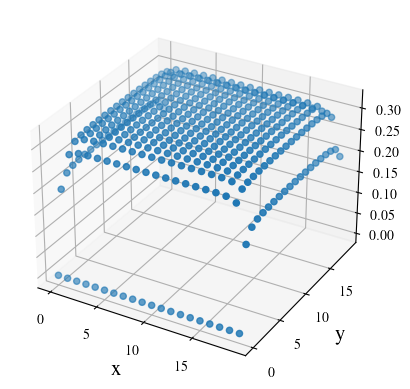

In [14]:
fig = plt.figure()
ax = plt.axes(projection="3d")

arr = np.arange(0,N,1)
Nx, Ny = np.meshgrid(arr,arr)

ax.scatter3D(Nx, Ny, rhoA2)

ax.set_xlabel("x",fontsize=15)
ax.set_ylabel("y",fontsize=15)
plt.show()

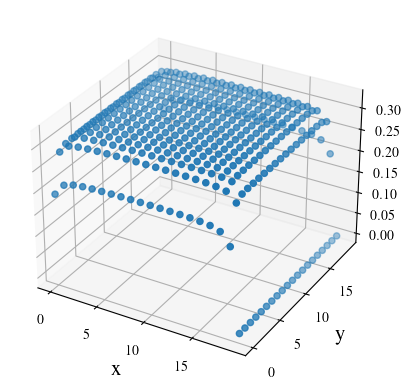

In [15]:
fig = plt.figure()
ax = plt.axes(projection="3d")

arr = np.arange(0,N,1)
Nx, Ny = np.meshgrid(arr,arr)

ax.scatter3D(Nx, Ny, rhoB2)

ax.set_xlabel("x",fontsize=15)
ax.set_ylabel("y",fontsize=15)
plt.show()

## Second way

In [16]:
eigval3, eigvect3 = eigh(HamOBC2(N))

In [17]:
rho3 = np.zeros(2*N**2,dtype="complex")
eta = -2*np.pi/(N**2)

coup = np.zeros((1,2*N**2))
coup[0,0] -= g
for j in range(2*N**2):
    coup1 = np.roll(coup,j)

    rho3[j] += np.sum(np.abs(np.dot(coup1,eigvect3))**2/(om_a-eigval3+1.j*eta))

rhoA3 = np.transpose(np.imag(rho3[:N**2].reshape(N,N)))
rhoB3 = np.transpose(np.imag(rho3[N**2:].reshape(N,N)))

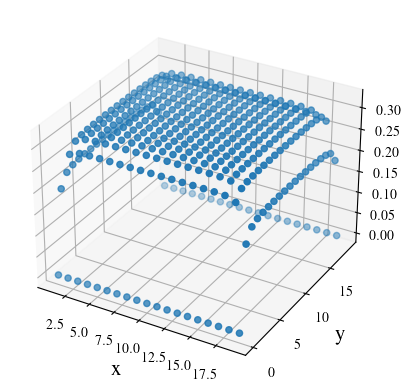

In [18]:
fig = plt.figure()
ax = plt.axes(projection="3d")

arr = np.arange(0,N,1)
Nx, Ny = np.meshgrid(arr,arr)

ax.scatter3D(Nx[:,1:], Ny[:,1:], rhoA3[:,1:])

ax.set_xlabel("x",fontsize=15)
ax.set_ylabel("y",fontsize=15)
plt.show()

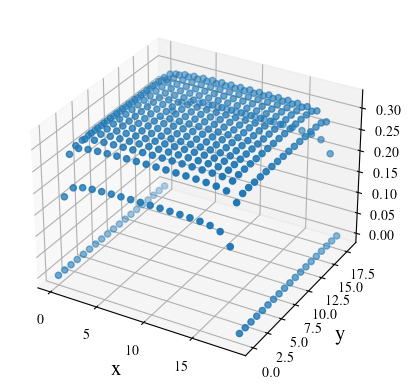

In [19]:
fig = plt.figure()
ax = plt.axes(projection="3d")

arr = np.arange(0,N,1)
Nx, Ny = np.meshgrid(arr,arr)

ax.scatter3D(Nx[:-1,:], Ny[:-1,:], rhoB3[:-1,:])

ax.set_xlabel("x",fontsize=15)
ax.set_ylabel("y",fontsize=15)
plt.show()

## Third way

In [20]:
eigval4, eigvect4 = eigh(HamOBC3(N))

In [21]:
rho4 = np.zeros(2*N**2,dtype="complex")
eta = -2*np.pi/(N**2)

coup = np.zeros((1,2*N**2))
coup[0,0] -= g
for j in range(2*N**2):
    coup1 = np.roll(coup,j)

    rho4[j] += np.sum(np.abs(np.dot(coup1,eigvect4))**2/(om_a-eigval4+1.j*eta))

rhoA4 = np.transpose(np.imag(rho4[:N**2].reshape(N,N)))
rhoB4 = np.transpose(np.imag(rho4[N**2:].reshape(N,N)))

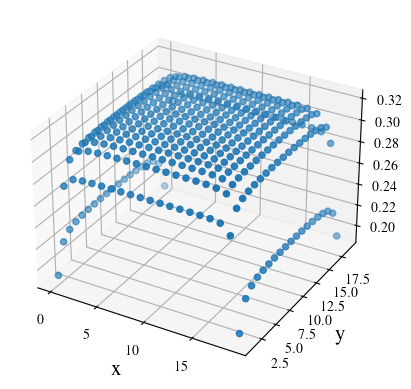

In [22]:
fig = plt.figure()
ax = plt.axes(projection="3d")

arr = np.arange(0,N,1)
Nx, Ny = np.meshgrid(arr,arr)

ax.scatter3D(Nx[1:], Ny[1:], rhoA4[1:])

ax.set_xlabel("x",fontsize=15)
ax.set_ylabel("y",fontsize=15)
plt.show()

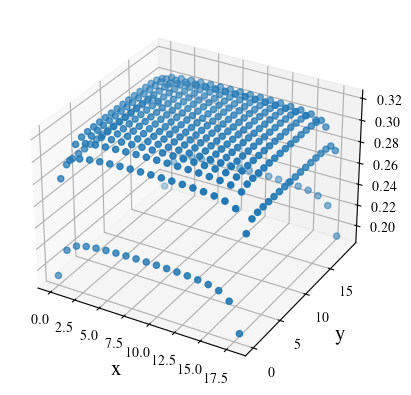

In [23]:
fig = plt.figure()
ax = plt.axes(projection="3d")

arr = np.arange(0,N,1)
Nx, Ny = np.meshgrid(arr,arr)

ax.scatter3D(Nx[:,:-1], Ny[:,:-1], rhoB4[:,:-1])

ax.set_xlabel("x",fontsize=15)
ax.set_ylabel("y",fontsize=15)
plt.show()

How much this behaviour depends on the FB, hence on the robust boundary modes? Let's repeat the calculation ignoring the contributions due to the dispersive band.

In [24]:
rho3 = np.zeros(2*N**2,dtype="complex")
eta = -2*np.pi/(N**2)

coup = np.zeros((1,2*N**2))
coup[0,0] -= g
eigvc = eigvect2[:,:N**2+1]
eigvl = eigval2[:N**2+1]
for j in range(2*N**2):
    coup1 = np.roll(coup,j)

    rho3[j] += np.sum(np.abs(np.dot(coup1,eigvc))**2/(om_a-eigvl+1.j*eta))

rhoA3 = np.transpose(np.imag(rho3[:N**2].reshape(N,N)))
rhoB3 = np.transpose(np.imag(rho3[N**2:].reshape(N,N)))

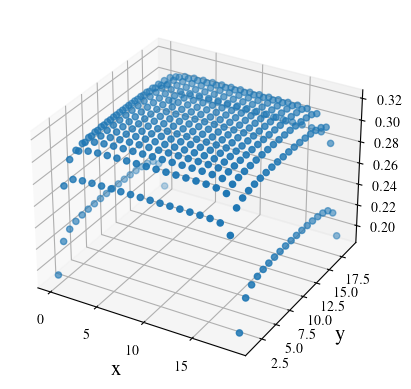

In [25]:
fig = plt.figure()
ax = plt.axes(projection="3d")

arr = np.arange(0,N,1)
Nx, Ny = np.meshgrid(arr,arr)

ax.scatter3D(Nx[1:], Ny[1:], rhoA3[1:])

ax.set_xlabel("x",fontsize=15)
ax.set_ylabel("y",fontsize=15)
plt.show()

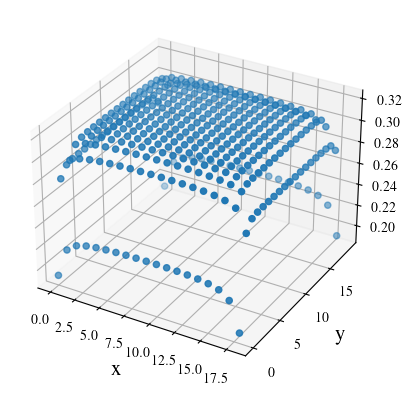

In [26]:
fig = plt.figure()
ax = plt.axes(projection="3d")

arr = np.arange(0,N,1)
Nx, Ny = np.meshgrid(arr,arr)

ax.scatter3D(Nx[:,:-1], Ny[:,:-1], rhoB3[:,:-1])

ax.set_xlabel("x",fontsize=15)
ax.set_ylabel("y",fontsize=15)
plt.show()